In [1]:
import sys
import climin
from functools import partial
import warnings
import os
sys.path.append('..')

import numpy as np
from scipy.stats import multinomial
from scipy.linalg.blas import dtrmm

import GPy
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg

from likelihoods.bernoulli import Bernoulli
from likelihoods.gaussian import Gaussian
from likelihoods.categorical import Categorical
from likelihoods.hetgaussian import HetGaussian
from likelihoods.beta import Beta
from likelihoods.gamma import Gamma
from likelihoods.exponential import Exponential

from hetmogp.util import draw_mini_slices
from hetmogp.het_likelihood import HetLikelihood
from hetmogp.model import HetMOGP
from hetmogp import multi_output
from hetmogp import util
from hetmogp.util import vem_algorithm as VEM

import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams
#from matplotlib2tikz import save as tikz_save

warnings.filterwarnings("ignore")
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
M = 10  # number of inducing points
Q = 1  # number of latent functions

# Heterogeneous Likelihood Definition
# likelihoods_list = [Gaussian(sigma=1.), Bernoulli()] # Real + Binary
#likelihoods_list = [Bernoulli(), Bernoulli()] # Real + Binary
likelihoods_list = [Gaussian(sigma=1.),Gaussian(sigma=1.)]

likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()

D = likelihood.num_output_functions(Y_metadata)

W_list, _ = multi_output.random_W_kappas(Q, D, rank=1, experiment=True)



In [82]:
N = 30
X1 = np.c_[np.arange(1,N+1),np.arange(0,N)]
Y1 = np.sin(X1[:,0]/5)
res = 2
#X2 = np.c_[np.arange(res,N+res,res),np.arange(0,N,res)]
#Y2 = np.mean(Y1.reshape([int(N/2),2]),1)
X2 = np.array([[0,N]])
Y2 = np.array([2.0])
Y1*=10

In [83]:
print('X1.shape:', X1.shape)
print('Y1.shape:', Y1.shape)
print('X2.shape:', X2.shape)
print('Y2.shape:', Y2.shape)

X1.shape: (30, 2)
Y1.shape: (30,)
X2.shape: (1, 2)
Y2.shape: (1,)


In [84]:
x1_new = np.zeros((X1.shape[0], X1.shape[1]+1))
x1_new[:,:-1] = X1.copy()

In [85]:
x2_new = np.zeros((X2.shape[0], X2.shape[1]+1))
x2_new[:,:-1] = X2.copy()

In [86]:
X = [x1_new, x2_new]

In [87]:
Y = [Y1[:,None], Y2[:, None]]

In [88]:
# KERNELS
input_dim = 3
ls_q = np.array(([.05]*Q))
var_q = np.array(([.5]*Q))
kern_list = multi_output.latent_functions_prior(Q, lengthscale=[ls_q], variance=[var_q], input_dim=input_dim,kernel=GPy.kern.Mix_Integral_)

# My kernel needs to get the lengthscale like this for two dimesional data lenghtscale=[1.0, 1.0]
# It doesn't need to be on, just two numbers
# Although my data looks 5 dimensional it is actually two dimensional and the kernel handles that in the background)

In [89]:
def callback(i):
    if i['n_iter'] > 1500:
        return True
    return False

In [90]:
X_ = np.vstack((X[0], X[1]))
from sklearn.cluster import KMeans
kmeans_X = KMeans(n_clusters=10, random_state=0).fit(X_)
Z = kmeans_X.cluster_centers_
Z[:,-1] = 1

In [91]:
Z

array([[28.5, 27.5,  1. ],
       [ 7.5,  6.5,  1. ],
       [18.5, 17.5,  1. ],
       [ 0. , 30. ,  1. ],
       [11.5, 10.5,  1. ],
       [ 2. ,  1. ,  1. ],
       [22.5, 21.5,  1. ],
       [15. , 14. ,  1. ],
       [ 4.5,  3.5,  1. ],
       [25.5, 24.5,  1. ]])

In [92]:
X1.shape

(30, 2)

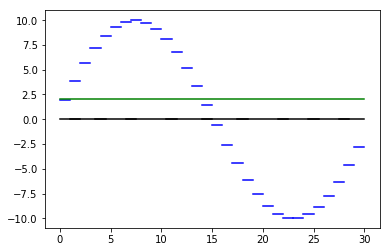

In [93]:
for xend,xstart,y in zip(X1[:,0],X1[:,1],Y1):
    plt.plot([xstart,xend],[y,y],'b-')
for xend,xstart,y in zip(X2[:,0],X2[:,1],Y2):
    plt.plot([xstart,xend],[y,y],'g-')    
for i,(zend,zstart) in enumerate(zip(Z[:,0],Z[:,1])):
    plt.plot([zstart,zend],[i*0.003,i*0.003],'k-')

In [94]:
# MODEL and INFERENCE
model = HetMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata)

In [95]:
vem_model=VEM(model,vem_iters=5,maxIter_perVEM=100,optZ=False,verbose=False,verbose_plot=False,non_chained=True)

iteration (1) VE step, log_likelihood=[-815.83080854]
iteration (1) VM step, log_likelihood=[-815.55309126]
iteration (2) VE step, log_likelihood=[-815.52008902]
iteration (2) VM step, log_likelihood=[-815.51499854]
iteration (3) VE step, log_likelihood=[-815.50161577]
iteration (3) VM step, log_likelihood=[-815.49354328]
iteration (4) VE step, log_likelihood=[-815.4630335]
iteration (4) VM step, log_likelihood=[-808.90263412]
iteration (5) VE step, log_likelihood=[-500.07570517]
iteration (5) VM step, log_likelihood=[-57.392383]


In [96]:
model.kern

kern_q0.,value,constraints,priors
variance,2.561706214587128,+ve,
lengthscale,5.8516936672350655,+ve,


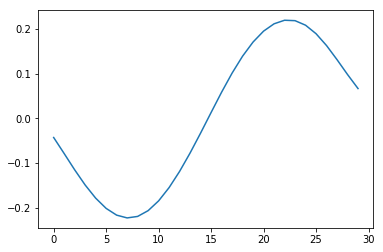

In [97]:
plt.plot(model.predictive(np.c_[X1,np.zeros(len(X1))],output_function_ind=1)[0])